<a href="https://colab.research.google.com/github/abdalrahmenyousifMohamed/ML/blob/main/Machine%20Projects/Credit_Card_Fraud_Detection_With_Machine_Learning_in_Python(just_basic_steps).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# Imported Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [9]:
# ! pip install kaggle


# ! mkdir ~/.kaggle


# ! cp kaggle.json ~/.kaggle/


# ! chmod 600 ~/.kaggle/kaggle.json

In [10]:
#  ! kaggle datasets download -d mlg-ulb/creditcardfraud

In [11]:
#  ! unzip /content/creditcardfraud.zip

In [12]:
# IMPORTING DATA

df = pd.read_csv('creditcard.csv')
#df.drop('Time', axis = 1, inplace = True)

print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [14]:
from termcolor import colored as cl # text customization

cases = len(df)
nonfraud_count = len(df[df.Class == 0])
fraud_count = len(df[df.Class == 1])
fraud_percentage = round(fraud_count/nonfraud_count*100, 2)

print(cl('CASE COUNT', attrs = ['bold']))
print(cl('--------------------------------------------', attrs = ['bold']))
print(cl('Total number of cases are {}'.format(cases), attrs = ['bold']))
print(cl('Number of Non-fraud cases are {}'.format(nonfraud_count), attrs = ['bold']))
print(cl('Number of Non-fraud cases are {}'.format(fraud_count), attrs = ['bold']))
print(cl('Percentage of fraud cases is {}'.format(fraud_percentage), attrs = ['bold']))
print(cl('--------------------------------------------', attrs = ['bold']))

CASE COUNT
--------------------------------------------
Total number of cases are 284807
Number of Non-fraud cases are 284315
Number of Non-fraud cases are 492
Percentage of fraud cases is 0.17
--------------------------------------------


**Note**: Notice how imbalanced is our original dataset! Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!



Text(0.5, 1.0, 'Class Distribution \n (0: No Fraud || 1 : Fraud')

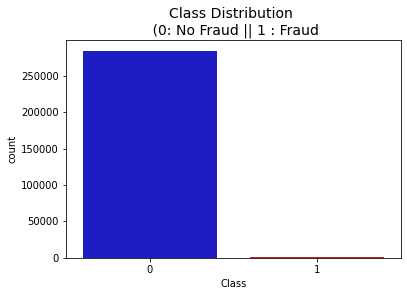

In [15]:
from IPython.core.formatters import PlainTextFormatter
colors = ["#0101df" , "#df0101"]
sns.countplot('Class' , data=df , palette = colors)
plt.title('Class Distribution \n (0: No Fraud || 1 : Fraud',fontsize=14)


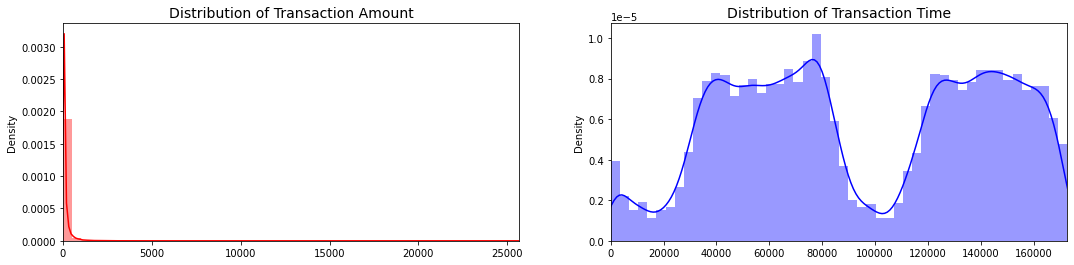

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

# Scaling & Distribution

In [17]:
df.Time

0              0.0
1              0.0
2              1.0
3              1.0
4              2.0
            ...   
284802    172786.0
284803    172787.0
284804    172788.0
284805    172788.0
284806    172792.0
Name: Time, Length: 284807, dtype: float64

In [18]:
# Since most of our datahas already been scaled we should scale the columns that are left to scale (Amount and Time)

from sklearn.preprocessing import StandardScaler , RobustScaler

# RobustScaler is less prone to outliers

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time' , 'Amount'] , axis=1 , inplace=True)

In [19]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960


In [20]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount' , 'scaled_time'] , axis=1,inplace=True)
df.insert(0 , 'scaled_amount' , scaled_amount)
df.insert(1,'scaled_time' , scaled_time)

# Amount and Time are Scaled !
df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


# Splitting The Data (Original DataFrame)

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

X = df.drop('Class' , axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5 , random_state = None , shuffle=False)

for train_index , test_index in sss.split(X,y):
  print(f'Train : {train_index} , Test : {test_index}')
  original_Xtrain , original_Xtest = X.iloc[train_index] , X.iloc[test_index]
  original_ytrain , original_ytest = y.iloc[train_index] , y.iloc[test_index]


# Turn into array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# see if both the train and test label distribution are similarly distributed

train_unique_label  , train_counts_label = np.unique(original_ytrain , return_counts=True)
test_unique_label  , test_counts_label = np.unique(original_ytest , return_counts=True)

print('-' * 100)

print('Label Distribution: \n')
print(train_counts_label / len(original_ytrain))
print(test_counts_label / len(original_ytest))

Train : [ 30473  30496  31002 ... 284804 284805 284806] , Test : [    0     1     2 ... 57017 57018 57019]
Train : [     0      1      2 ... 284804 284805 284806] , Test : [ 30473  30496  31002 ... 113964 113965 113966]
Train : [     0      1      2 ... 284804 284805 284806] , Test : [ 81609  82400  83053 ... 170946 170947 170948]
Train : [     0      1      2 ... 284804 284805 284806] , Test : [150654 150660 150661 ... 227866 227867 227868]
Train : [     0      1      2 ... 227866 227867 227868] , Test : [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distribution: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


# Random Under-Sampling
After implementing this technique, we have a sub-sample of our dataframe with a 50/50 ratio with regards to our classes. Then the next step we will implement is to shuffle the data to see if our models can maintain a certain accuracy everytime we run this script.


In [22]:
# Let's shuffle the data before creating the subsamples

df = df.sample(frac=1)

# amount of fraud classes 492
fraud_df = df.loc[df['Class']==1]
non_fraud_df = df.loc[df['Class']==0][:492]

normal_distributed_df = pd.concat([fraud_df , non_fraud_df])

# shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1 , random_state=42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
131865,0.684972,-0.057872,0.964080,-0.182534,1.366113,1.398569,-1.032812,-0.090500,-0.486917,0.103258,...,0.001198,0.235902,0.783067,-0.063055,0.648671,0.370924,-0.270900,0.079286,0.050813,0
6719,-0.293440,-0.896122,-0.251471,4.313523,-6.891438,6.796797,0.616297,-2.966327,-2.436653,0.489328,...,0.632710,0.536892,-0.546126,-0.605240,-0.263743,1.539916,0.523574,0.891025,0.572741,1
93096,0.670719,-0.240170,1.013542,-0.854567,0.747367,-1.421814,-0.947738,0.379689,-0.813444,0.329704,...,0.023181,0.265525,0.935297,-0.119401,-0.186176,0.296092,0.147470,0.064675,0.018807,0
15736,1.089779,-0.675866,-23.914101,13.765942,-25.733734,6.290918,-17.784824,-4.572498,-17.390764,15.794136,...,1.640037,1.773399,-1.748426,-1.093104,0.147807,1.663792,-0.221024,1.458076,0.430315,1
46909,-0.293440,-0.489985,-4.075975,0.963031,-5.076070,4.955963,-0.161437,-2.832663,-7.619765,1.618895,...,0.058861,1.030738,0.165328,-1.017502,-0.477983,-0.304987,-0.106089,1.899714,0.511462,1


Equally Distributing and Correlating:
Now that we have our dataframe correctly balanced, we can go further with our analysis and data preprocessing

Distribution of the Classes in the subsample dataset
0    0.5
1    0.5
Name: Class, dtype: float64


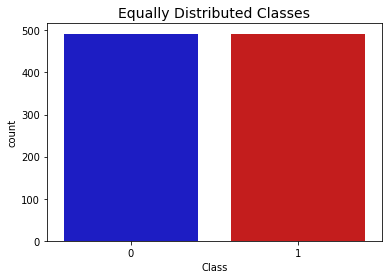

In [23]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))



sns.countplot('Class', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

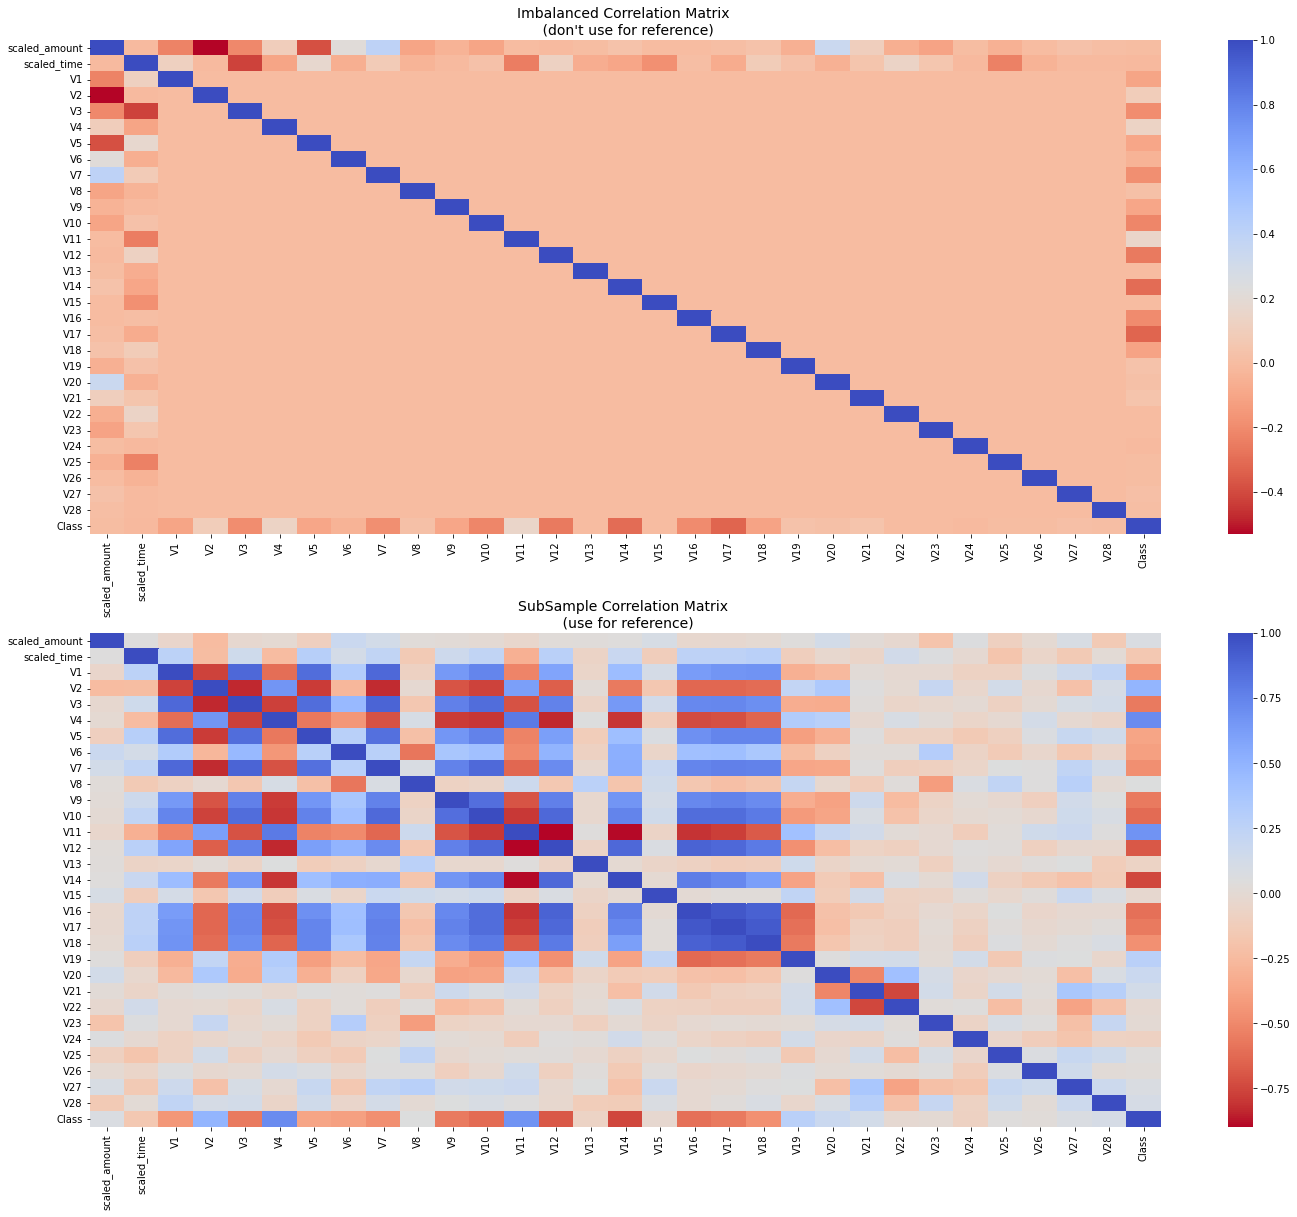

In [24]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

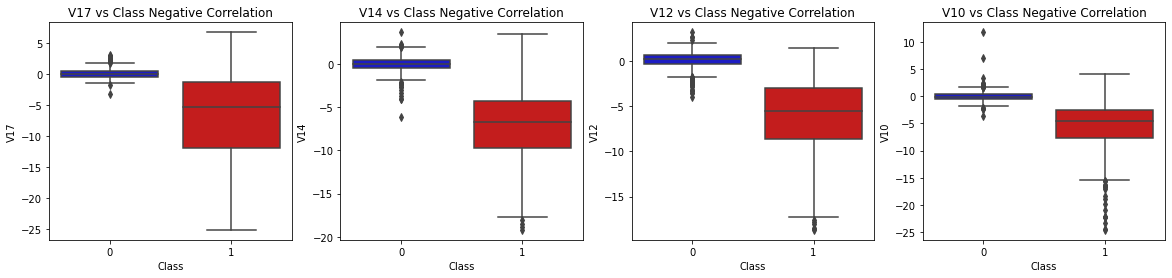

In [25]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

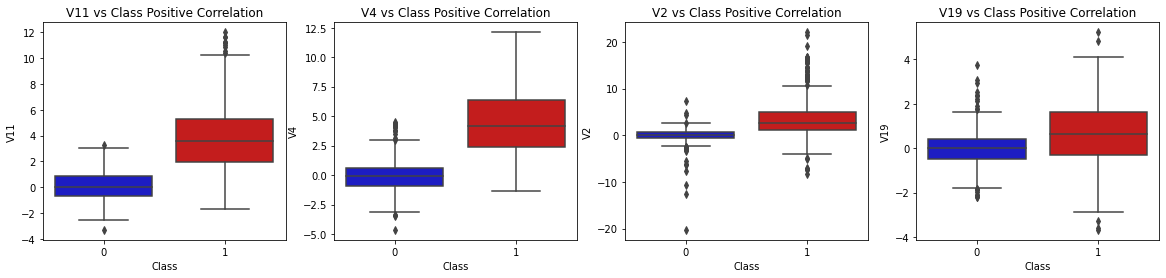

In [26]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

# Anomaly Detection
- our main aim in this section to remove "extreme outliers" from features that have a high correlation with our classes. This will have a positive impact on the accuracy of our models

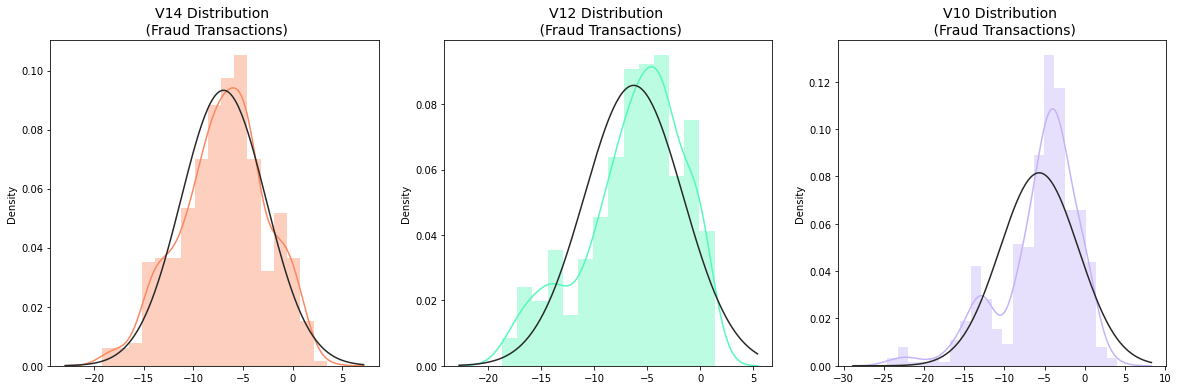

In [27]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [28]:
# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)

# -----> V12 removing outliers from fraud transactions
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


# Removing outliers V10 Feature
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))

Quartile 25: -9.692722964972386 | Quartile 75: -4.282820849486865
iqr: 5.409902115485521
Cut Off: 8.114853173228282
V14 Lower: -17.807576138200666
V14 Upper: 3.8320323237414167
Feature V14 Outliers for Fraud Cases: 4
V10 outliers:[-18.8220867423816, -18.0499976898594, -18.4937733551053, -19.2143254902614]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
V12 outliers: [-18.4311310279993, -18.6837146333443, -18.0475965708216, -18.5536970096458]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 976
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lower: -14.89885463232024
V10 Upper: 4.92033495834214
V10 outliers: [-15.5637913387301, -15.239961

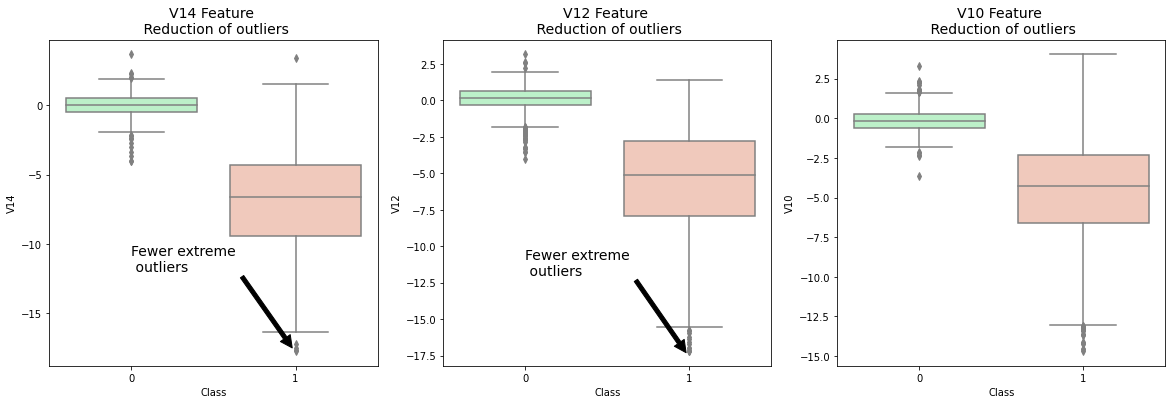

In [29]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)


plt.show()

# Dimensionality Reduction and Clustering

**Understanding t-SNE**
In order to understand this algorithm you have to understand the following terms:

- Euclidean Distance
- Conditional Probability
- Normal and T-Distribution Plots
. 
- t-SNE algorithm can pretty accurately cluster the cases that were fraud and non-fraud in our dataset.
Although the subsample is pretty small, the t-SNE algorithm is able to detect clusters pretty accurately in every scenario (I shuffle the dataset before running t-SNE)
This gives us an indication that further predictive models will perform pretty well in separating fraud cases from non-fraud cases.

In [31]:
from scipy.stats.distributions import t
# New_df is from the random undersample data (fewer instances)

X = new_df.drop('Class' , axis=1)
y = new_df['Class']

# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2 , random_state=42).fit_transform(X.values)
t1 = time.time()

print("T-SNE TOOK {:.2} s".format(t1-t0))

# PCA Implementation
t0 = time.time()
X_reduced_PCA = PCA(n_components=2 , random_state=42).fit_transform(X.values)
t1 = time.time()
print('PCA took {:.2} s'.format(t1-t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2 , algorithm='randomized' , random_state=42).fit_transform(X.values)
t1 = time.time()
print('Truncated SVD took {:.2} s'.format(t1 - t0))

T-SNE TOOK 5.3 s
PCA took 0.015 s
Truncated SVD took 0.0055 s


In [36]:
plt.scatter?

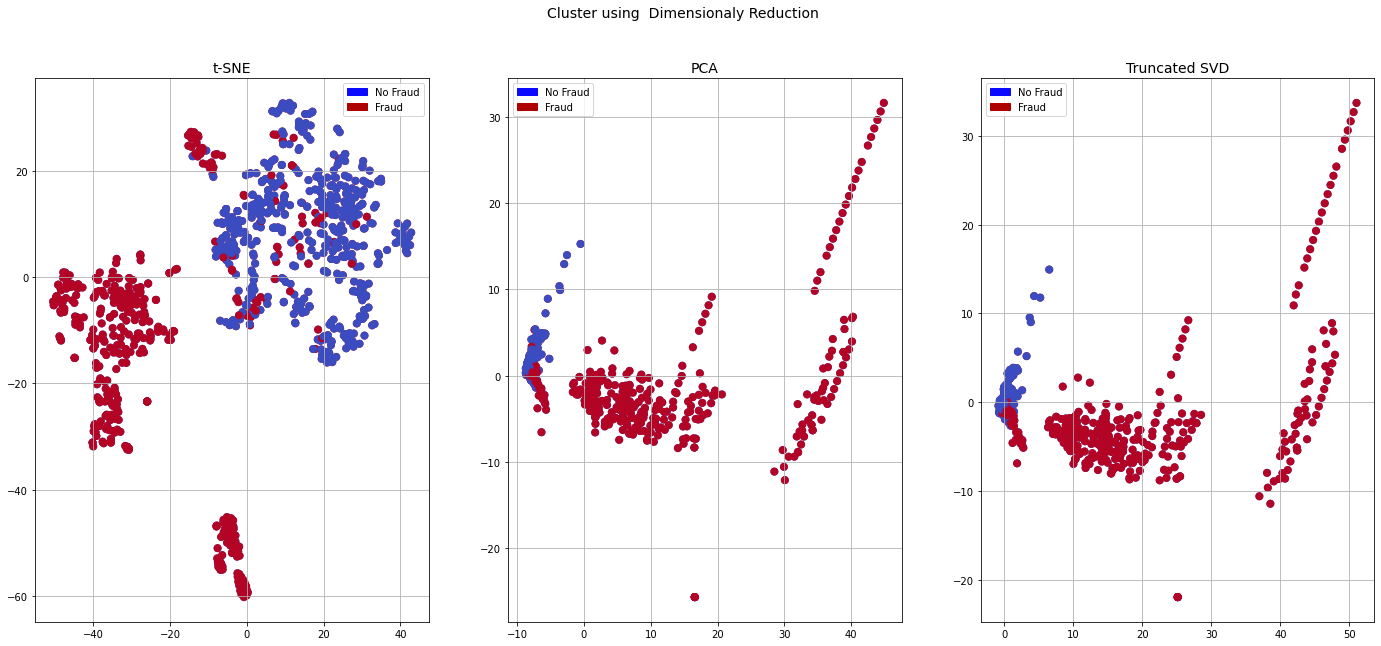

In [37]:
f , (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(24,10))
# labels = ['No Fraud' , 'Fraud']
f.suptitle('Cluster using  Dimensionaly Reduction' , fontsize=14)

blue_patch = mpatches.Patch(color='#0A0AFF' , label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000' , label='Fraud')

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0] , X_reduced_tsne[:,1],c=(y==0) , cmap='coolwarm',
            label='No Fraud' , linewidths=2
            )
ax1.scatter(X_reduced_tsne[:,0] , X_reduced_tsne[:,1],c=(y==1) , cmap='coolwarm',
            label='Fraud' , linewidths=2
            )
ax1.set_title('t-SNE' , fontsize=14)
ax1.grid(True)

ax1.legend(handles=[blue_patch , red_patch])

# PCA scatter plot
ax2.scatter(X_reduced_PCA[:,0], X_reduced_PCA[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_PCA[:,0], X_reduced_PCA[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

# Classifiers (UnderSampling)

- In this section we will train four types of classifier and decide which classifier will be more effective in detecting fraud transactions.
Before we have to split our data into training and testing sets and separate the features from the labels.

# Summary
 - Logistic Regression classifier is more accurate than the other three classifiers in most cases. (We will further analyze Logistic Regression)
- GridSearchCV is used to determine the paremeters that gives the best predictive score for the classifiers.
- Logistic Regression has the best Receiving Operating Characteristic score (ROC), meaning that LogisticRegression pretty accurately separates fraud and non-fraud transactions.

# Learning Curves : 
- The **wider the gap** between the training score and the cross validation score , the more likely your model is **overfitting (high variance)**

- if the score is low in both training and cross-validation sets this is an indication that our model is underfitting (high bias)

- Logistic Regression Classifier shows the best score in both training and cross-validating sets

In [ ]:
# Undersampling before cross validation (prone to overfit)

X = new_df.drop('Class' , axis=1)
y = new_df['Class']

In [39]:
# Our data is already scaled we should split our training and test sets

from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train , X_test , y_train , y_test = train_test_split(X,y , test_size=0.2 , random_state=42)

In [40]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [41]:
# Let's implement simple classifiers

classifiers = {
    'LogisticRegression' : LogisticRegression(),
    'KNearest' : KNeighborsClassifier() , 
    'Support Vector Classifier' : SVC(),
    'DecisionTreeClassifier' : DecisionTreeClassifier()
}

In [42]:
# Notice our scores are getting even high scores even when applying cross validation
from sklearn.model_selection import cross_val_score


for key , classifier in classifiers.items():
  classifier.fit(X_train , y_train)
  training_score = cross_val_score(classifier , X_train , y_train , cv=5)
  print('Classifiers : ' , classifier.__class__.__name__ , "Has a training score of " , round(training_score.mean(),2)*100 , "% accuracy score")

Classifiers :  LogisticRegression Has a training score of  94.0 % accuracy score
Classifiers :  KNeighborsClassifier Has a training score of  93.0 % accuracy score
Classifiers :  SVC Has a training score of  92.0 % accuracy score
Classifiers :  DecisionTreeClassifier Has a training score of  90.0 % accuracy score


In [43]:
# Use GridSearch to find the best parameters.

from sklearn.model_selection import GridSearchCV

# Logistic Regression

log_reg_params = {'penalty' : ['l1' , 'l2'] , 'C' : [0.001 , 0.01 , 0.1 , 1 ,10 , 100 , 1000]}

grid_log_reg = GridSearchCV(LogisticRegression() , log_reg_params)
grid_log_reg.fit(X_train , y_train)

# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

knears_params = {'n_neighbors' : list(range(2,5,1)),'algorithm' : ['auto' , 'ball_tree' , 'kd_tree' , 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier() , knears_params)

grid_knears.fit(X_train , y_train)
#KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C' : [0.5 , 0.7,0.9,1], 'kernel' :['rbf' , 'poly' , 'sigmoid' , 'linear']}

grid_svc = GridSearchCV(SVC() ,svc_params)
grid_svc.fit(X_train , y_train)

# SVC best estimator

svc = grid_svc.best_estimator_

# Decision tree classifier
tree_params = {'criterion' : ['gini' , 'entropy'] , "max_depth" : list(range(2,4,1)),
               
               
               'min_samples_leaf' : list(range(5,7,1))}

grid_tree = GridSearchCV(DecisionTreeClassifier() , tree_params)
grid_tree.fit(X_train , y_train)

# tree best estimator

tree_clf = grid_tree.best_estimator_


In [44]:
# Overfitting Case

log_reg_score = cross_val_score(log_reg , X_train , y_train , cv=5)

print('Logistic Regression Cross Validation Score : ' , round(log_reg_score.mean()*100,2).astype(str) + '%')

knears_score = cross_val_score(knears_neighbors , X_train , y_train , cv=5)

print('Knears Neighbors Cross Validation Score' , round(knears_score.mean()*100,2).astype(str) + '%')

svc_score = cross_val_score(svc , X_train , y_train , cv=5)

print('Support Vector Classifier Cross Validation Score : ' , round(svc_score.mean()*100,2).astype(str) + '%')

tree_score = cross_val_score(tree_clf , X_train , y_train , cv=5)

print('DecisionTree Classifier Cross Validation Score' , round(tree_score.mean()*100,2).astype(str) + '%')

Logistic Regression Cross Validation Score :  93.93%
Knears Neighbors Cross Validation Score 93.27%
Support Vector Classifier Cross Validation Score :  93.53%
DecisionTree Classifier Cross Validation Score 92.47%


In [48]:
# We will undersample during cross validating
undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementing NearMiss Technique 
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
X_nearmiss, y_nearmiss = NearMiss().fit_resample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))

# Cross Validating the right way

for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) # SMOTE happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

Train: [ 56959  56960  56961 ... 284804 284805 284806] Test: [    0     1     2 ... 57050 59731 59872]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 56959  56960  56961 ... 113926 113927 113928]
Train: [     0      1      2 ... 284804 284805 284806] Test: [112136 112423 113407 ... 170892 170893 170894]
Train: [     0      1      2 ... 284804 284805 284806] Test: [164281 164392 166882 ... 227852 227853 227854]
Train: [     0      1      2 ... 227852 227853 227854] Test: [220140 220270 221341 ... 284804 284805 284806]
NearMiss Label Distribution: Counter({0: 492, 1: 492})
NearMiss feature Distribution: 984


In [49]:
# Let's Plot LogisticRegression Learning Curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Second Estimator 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py'>

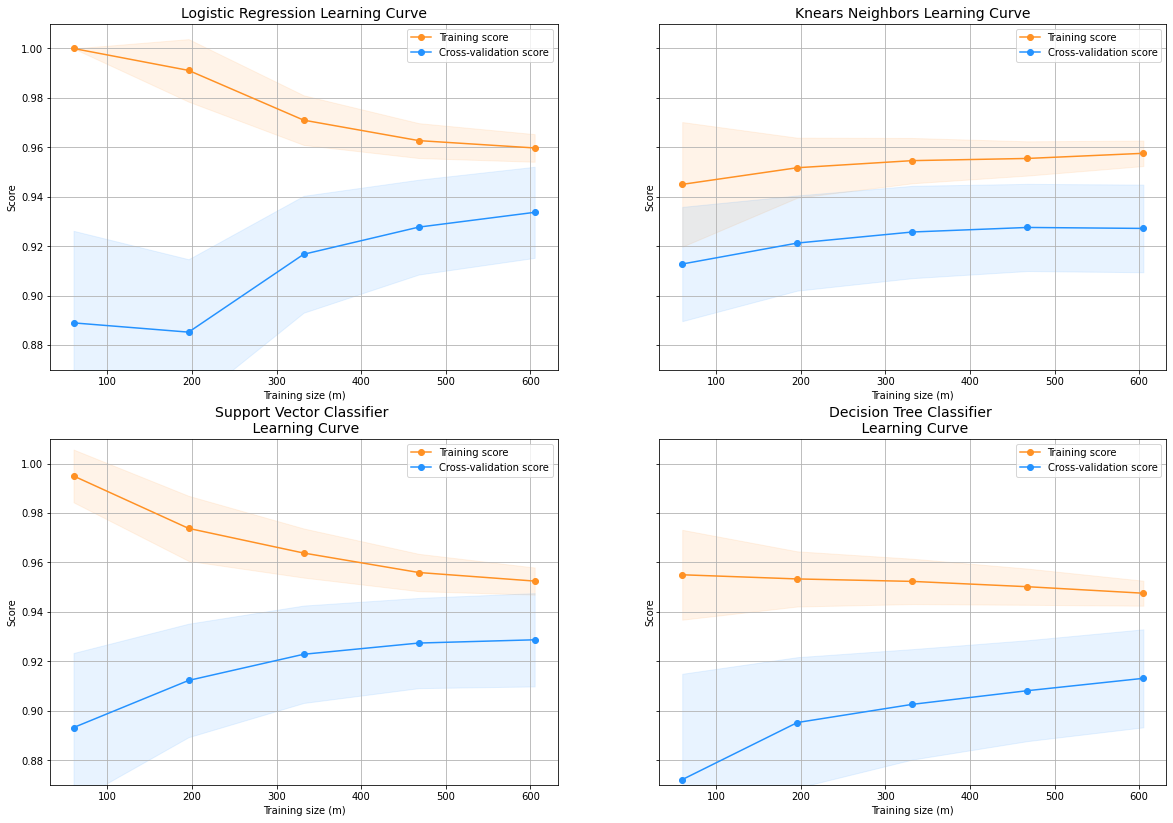

In [50]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

In [51]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

In [52]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.9737580827618955
KNears Neighbors:  0.9320000558635811
Support Vector Classifier:  0.96731282208846
Decision Tree Classifier:  0.9257328603550131


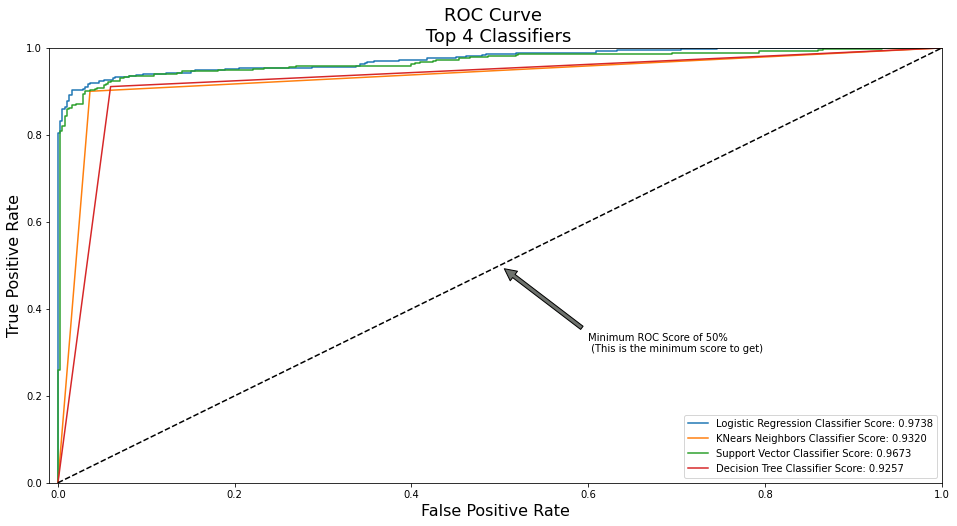

In [55]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

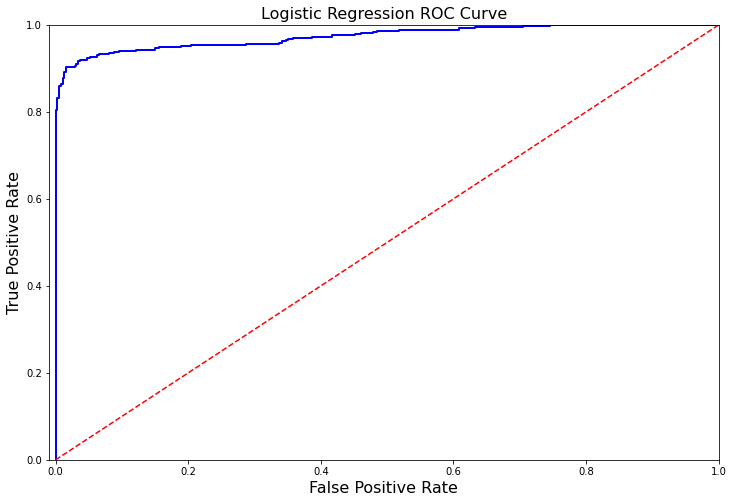

In [56]:
def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
    
    
logistic_roc_curve(log_fpr, log_tpr)
plt.show()

In [57]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train, log_reg_pred)

In [58]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
y_pred = log_reg.predict(X_train)

# Overfitting Case
print('---' * 45)
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('---' * 45)

# How it should look like
print('---' * 45)
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
Overfitting: 

Recall Score: 0.95
Precision Score: 0.64
F1 Score: 0.77
Accuracy Score: 0.71
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
How it should be:

Accuracy Score: 0.53
Precision Score: 0.00
Recall Score: 0.47
F1 Score: 0.00
---------------------------------------------------------------------------------------------------------------------------------------


In [59]:
undersample_y_score = log_reg.decision_function(original_Xtest)

In [60]:
from sklearn.metrics import average_precision_score

undersample_average_precision = average_precision_score(original_ytest, undersample_y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      undersample_average_precision))

Average precision-recall score: 0.01


Text(0.5, 1.0, 'UnderSampling Precision-Recall curve: \n Average Precision-Recall Score =0.01')

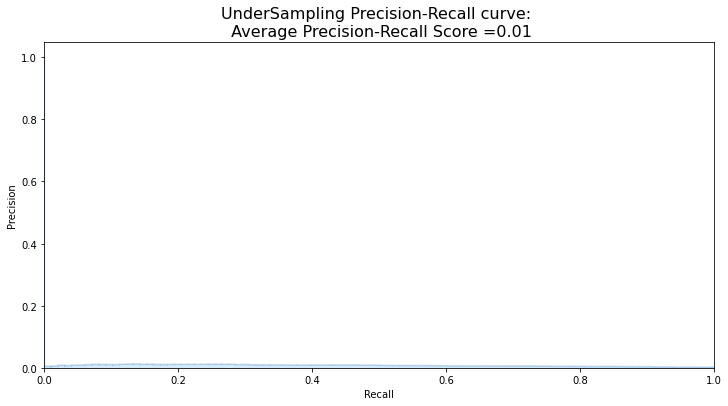

In [61]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, undersample_y_score)

plt.step(recall, precision, color='#004a93', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#48a6ff')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          undersample_average_precision), fontsize=16)

In [65]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV


print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()



log_reg_params = {"penalty": ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)


# Implementing SMOTE Technique 
# Cross Validating the right way
# Parameters
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)


Length of X (train): 227846 | Length of y (train): 227846
Length of X (test): 56961 | Length of y (test): 56961
---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9707655113758644
precision: 0.065207066519298
recall: 0.9112301200908796
f1: 0.12057231650914702
---------------------------------------------------------------------------------------------------------------------------------------


In [66]:
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.99      0.99     56863
       Fraud       0.11      0.86      0.19        98

    accuracy                           0.99     56961
   macro avg       0.55      0.92      0.59     56961
weighted avg       1.00      0.99      0.99     56961



In [67]:
y_score = best_est.decision_function(original_Xtest)


In [68]:
average_precision = average_precision_score(original_ytest, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.74


Text(0.5, 1.0, 'OverSampling Precision-Recall curve: \n Average Precision-Recall Score =0.74')

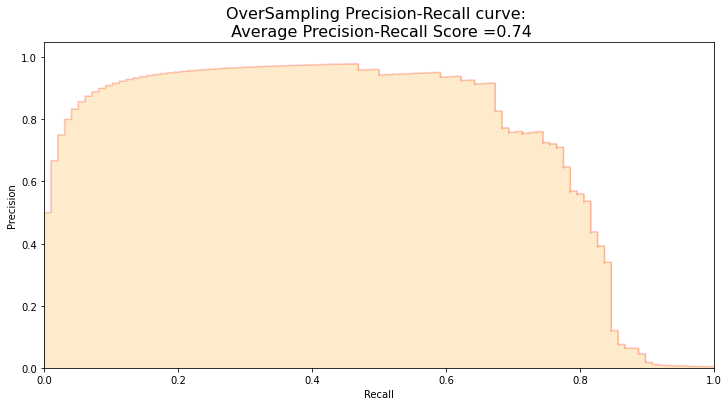

In [69]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

In [74]:

# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)


# This will be the data were we are going to 
Xsm_train, ysm_train = sm.fit_resample(original_Xtrain, original_ytrain)

In [75]:
# We Improve the score by 2% points approximately 
# Implement GridSearchCV and the other models.

# Logistic Regression
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

Fitting oversample data took :9.714405536651611 sec


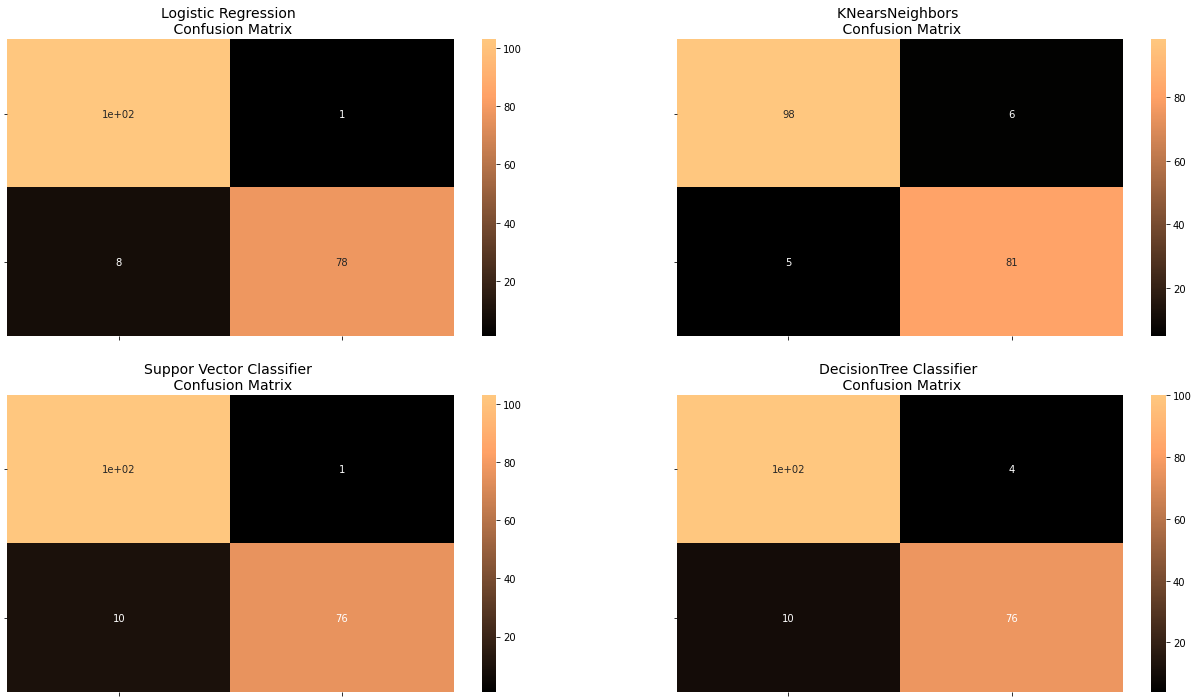

In [76]:
from sklearn.metrics import confusion_matrix

# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg_sm.predict(X_test)

# Other models fitted with UnderSampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)


log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)

fig, ax = plt.subplots(2, 2,figsize=(22,12))


sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()

In [77]:
from sklearn.metrics import classification_report


print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))

print('KNears Neighbors:')
print(classification_report(y_test, y_pred_knear))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_svc))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_tree))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       104
           1       0.99      0.91      0.95        86

    accuracy                           0.95       190
   macro avg       0.96      0.95      0.95       190
weighted avg       0.95      0.95      0.95       190

KNears Neighbors:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       104
           1       0.93      0.94      0.94        86

    accuracy                           0.94       190
   macro avg       0.94      0.94      0.94       190
weighted avg       0.94      0.94      0.94       190

Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       104
           1       0.99      0.88      0.93        86

    accuracy                           0.94       190
   macro avg       0.95      0.94      0.94       190
weighted

In [78]:
# Final Score in the test set of logistic regression
from sklearn.metrics import accuracy_score

# Logistic Regression with Under-Sampling
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)



# Logistic Regression with SMOTE Technique (Better accuracy with SMOTE t)
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)


d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

# Move column
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

# Note how high is accuracy score it can be misleading! 
final_df

,Technique,Score
0,Random UnderSampling,0.952632
1,Oversampling (SMOTE),0.987395


Neural Networks Testing Random UnderSampling Data vs OverSampling (SMOTE):
In this section we will implement a simple Neural Network (with one hidden layer) in order to see which of the two logistic regressions models we implemented in the (undersample or oversample(SMOTE)) has a better accuracy for detecting fraud and non-fraud transactions.


Our Main Goal:
Our main goal is to explore how our simple neural network behaves in both the random undersample and oversample dataframes and see whether they can predict accuractely both non-fraud and fraud cases. Why not only focus on fraud? Imagine you were a cardholder and after you purchased an item your card gets blocked because the bank's algorithm thought your purchase was a fraud. That's why we shouldn't emphasize only in detecting fraud cases but we should also emphasize correctly categorizing non-fraud transactions.

The Confusion Matrix:
Here is again, how the confusion matrix works:

Upper Left Square: The amount of correctly classified by our model of no fraud transactions.
Upper Right Square: The amount of incorrectly classified transactions as fraud cases, but the actual label is no fraud .
Lower Left Square: The amount of incorrectly classified transactions as no fraud cases, but the actual label is fraud .
Lower Right Square: The amount of correctly classified by our model of fraud transactions.
Summary (Keras || Random UnderSampling):
Dataset: In this final phase of testing we will fit this model in both the random undersampled subset and oversampled dataset (SMOTE) in order to predict the final result using the original dataframe testing data.
Neural Network Structure: As stated previously, this will be a simple model composed of one input layer (where the number of nodes equals the number of features) plus bias node, one hidden layer with 32 nodes and one output node composed of two possible results 0 or 1 (No fraud or fraud).
Other characteristics: The learning rate will be 0.001, the optimizer we will use is the AdamOptimizer, the activation function that is used in this scenario is "Relu" and for the final outputs we will use sparse categorical cross entropy, which gives the probability whether an instance case is no fraud or fraud (The prediction will pick the highest probability between the two.)

In [79]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

n_inputs = X_train.shape[1]

undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [80]:
undersample_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 32)                992       
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1,988
Trainable params: 1,988
Non-trainable params: 0
_________________________________________________________________


In [81]:
undersample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [82]:
undersample_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)

Epoch 1/20
25/25 - 1s - loss: 0.5504 - accuracy: 0.6711 - val_loss: 0.3945 - val_accuracy: 0.8224 - 1s/epoch - 45ms/step
Epoch 2/20
25/25 - 0s - loss: 0.3608 - accuracy: 0.8595 - val_loss: 0.3062 - val_accuracy: 0.9079 - 120ms/epoch - 5ms/step
Epoch 3/20
25/25 - 0s - loss: 0.2775 - accuracy: 0.9190 - val_loss: 0.2625 - val_accuracy: 0.9145 - 111ms/epoch - 4ms/step
Epoch 4/20
25/25 - 0s - loss: 0.2288 - accuracy: 0.9289 - val_loss: 0.2386 - val_accuracy: 0.9211 - 119ms/epoch - 5ms/step
Epoch 5/20
25/25 - 0s - loss: 0.1990 - accuracy: 0.9339 - val_loss: 0.2271 - val_accuracy: 0.9276 - 99ms/epoch - 4ms/step
Epoch 6/20
25/25 - 0s - loss: 0.1775 - accuracy: 0.9388 - val_loss: 0.2211 - val_accuracy: 0.9276 - 116ms/epoch - 5ms/step
Epoch 7/20
25/25 - 0s - loss: 0.1624 - accuracy: 0.9372 - val_loss: 0.2201 - val_accuracy: 0.9276 - 119ms/epoch - 5ms/step
Epoch 8/20
25/25 - 0s - loss: 0.1498 - accuracy: 0.9455 - val_loss: 0.2163 - val_accuracy: 0.9276 - 109ms/epoch - 4ms/step
Epoch 9/20
25/25 - 

In [84]:
undersample_predictions = undersample_model.predict(original_Xtest, batch_size=200, verbose=0)
# undersample_fraud_predictions = undersample_model.predict_classes(original_Xtest, batch_size=200, verbose=0)
undersample_fraud_predictions = np.argmax(undersample_model.predict(original_Xtest), axis=-1)

1781/1781 [==============================] - 2s 1ms/step


In [85]:
undersample_predictions

array([[3.2721471e-02, 9.6727854e-01],
       [2.5607767e-06, 9.9999744e-01],
       [6.3602641e-02, 9.3639737e-01],
       ...,
       [9.7980839e-01, 2.0191655e-02],
       [9.9354595e-01, 6.4540105e-03],
       [9.0956658e-01, 9.0433434e-02]], dtype=float32)

In [86]:
undersample_fraud_predictions

array([1, 1, 1, ..., 0, 0, 0])

In [87]:
import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[55683  1180]
 [   10    88]]
Confusion matrix, without normalization
[[56863     0]
 [    0    98]]


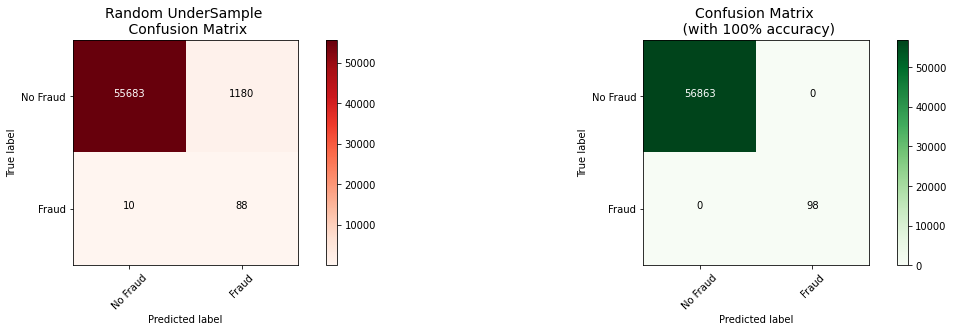

In [88]:
undersample_cm = confusion_matrix(original_ytest, undersample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(undersample_cm, labels, title="Random UnderSample \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

In [89]:
n_inputs = Xsm_train.shape[1]

oversample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [90]:
oversample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [91]:
oversample_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=300, epochs=20, shuffle=True, verbose=2)

Epoch 1/20
1214/1214 - 7s - loss: 0.0570 - accuracy: 0.9806 - val_loss: 0.0170 - val_accuracy: 0.9974 - 7s/epoch - 6ms/step
Epoch 2/20
1214/1214 - 4s - loss: 0.0116 - accuracy: 0.9975 - val_loss: 0.0116 - val_accuracy: 0.9995 - 4s/epoch - 3ms/step
Epoch 3/20
1214/1214 - 2s - loss: 0.0066 - accuracy: 0.9987 - val_loss: 0.0034 - val_accuracy: 1.0000 - 2s/epoch - 2ms/step
Epoch 4/20
1214/1214 - 3s - loss: 0.0048 - accuracy: 0.9991 - val_loss: 0.0027 - val_accuracy: 1.0000 - 3s/epoch - 2ms/step
Epoch 5/20
1214/1214 - 2s - loss: 0.0037 - accuracy: 0.9993 - val_loss: 0.0017 - val_accuracy: 0.9999 - 2s/epoch - 2ms/step
Epoch 6/20
1214/1214 - 3s - loss: 0.0031 - accuracy: 0.9994 - val_loss: 8.5717e-04 - val_accuracy: 1.0000 - 3s/epoch - 2ms/step
Epoch 7/20
1214/1214 - 3s - loss: 0.0028 - accuracy: 0.9995 - val_loss: 7.2350e-04 - val_accuracy: 1.0000 - 3s/epoch - 3ms/step
Epoch 8/20
1214/1214 - 3s - loss: 0.0023 - accuracy: 0.9996 - val_loss: 0.0016 - val_accuracy: 0.9997 - 3s/epoch - 2ms/step


In [92]:
oversample_predictions = oversample_model.predict(original_Xtest, batch_size=200, verbose=0)
oversample_fraud_predictions = np.argmax(oversample_model.predict(original_Xtest), axis=-1)

1781/1781 [==============================] - 3s 2ms/step


Confusion matrix, without normalization
[[56857     6]
 [   32    66]]
Confusion matrix, without normalization
[[56863     0]
 [    0    98]]


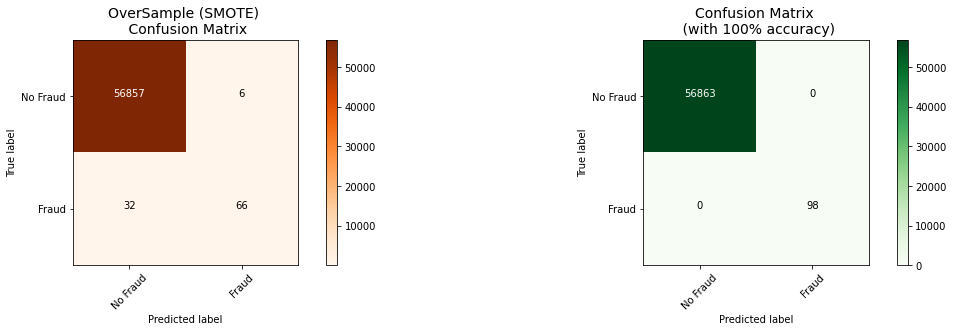

In [93]:
oversample_smote = confusion_matrix(original_ytest, oversample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(oversample_smote, labels, title="OverSample (SMOTE) \n Confusion Matrix", cmap=plt.cm.Oranges)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)